# Tarea 3
- Nombre: **Matías Duhalde**
- Número de alumno: **18639496**


## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import face_recognition as fr

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

## Define constants

In [ ]:
EMOTIONS = {
    0: 'enojo',
    1: 'asco',
    2: 'miedo',
    3: 'alegría',
    4: 'tristeza',
    5: 'sorpresa',
    6: 'neutral',
}

IMAGE_WIDTH = 48
IMAGE_HEIGHT = 48

## Load dataset

In [ ]:
CSV_PATH = 'mini_fer2013.csv'

df = pd.read_csv(CSV_PATH)

## Parte 1

### Helper functions

In [ ]:
def string_to_picture_array(string_):
    pixels = [int(x) for x in string_.split(" ")]
    array = np.empty((IMAGE_HEIGHT, IMAGE_WIDTH), dtype='uint8')
    for i in range(IMAGE_HEIGHT):
        for j in range(IMAGE_WIDTH):
            array[i][j] = pixels[i*IMAGE_HEIGHT+j]
    return array

def picture_array_to_fr_image(array):
    return array


### Preprocessing

In [ ]:
print(df[['Usage']].value_counts(normalize=True))
print(df[['emotion']].value_counts(normalize=True))

# Pixels to array
df['pixels'] = df['pixels'].apply(string_to_picture_array)

# Emotion to label
df['emotion'] = df['emotion'].apply(lambda x: EMOTIONS[x])

Usage
ToV      0.900641
Test     0.099359
dtype: float64
emotion
3          0.368415
6          0.232284
5          0.122552
0          0.116900
4          0.085140
2          0.067890
1          0.006818
dtype: float64


### Get one sample image per emotion

In [ ]:
emotion_sample = []
for emotion in EMOTIONS.values():
    emotion_sample.append(df[df.emotion == emotion].iloc[1])

### Show images

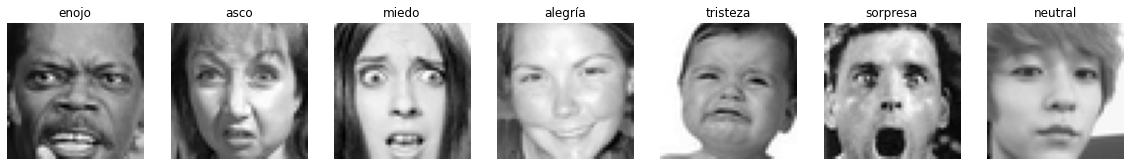

In [ ]:
fig, axs = plt.subplots(1, len(EMOTIONS))
fig.set_size_inches((20,4))

for i, row in enumerate(emotion_sample):
    axs[i].imshow(row['pixels'], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(row['emotion'])

### Face recognition (face_landmarks)

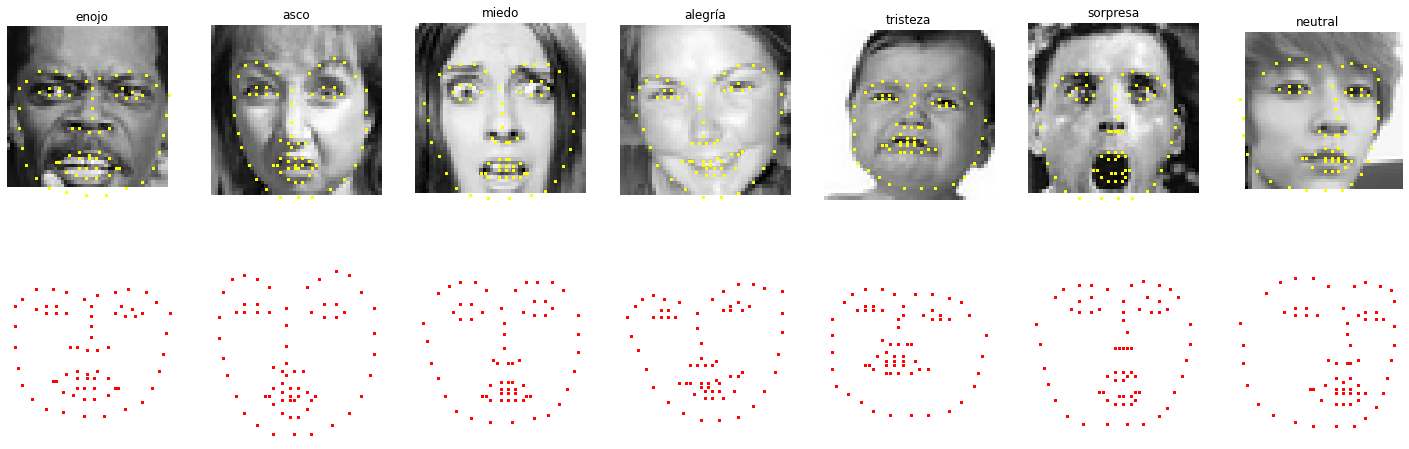

In [ ]:
fig, axs = plt.subplots(2, len(EMOTIONS))
fig.set_size_inches((25,8))

for i, row in enumerate(emotion_sample):
    image = row.pixels
    axs[0][i].imshow(row['pixels'], cmap='gray')
    axs[0][i].axis('off')
    axs[0][i].set_title(row['emotion'])
    res = fr.face_landmarks(image)
    if res:
        flatten = [item for sublist in res[0].values() for item in sublist]
        x, y = zip(*flatten)
        axs[0][i].scatter(x, y, 8, 'yellow', marker='s')
        axs[1][i].set_aspect('equal', adjustable='box')
        axs[1][i].axis('off')
        axs[1][i].invert_yaxis()
        axs[1][i].scatter(x, y, 8, 'red', marker='s')


## Parte 2

### Estrategia

El set de test ya venía predefinido según la columna **'Usage'** de los datos originales, y corresponde aproximadamente al $10\%$ de los datos. Por lo tanto, los sets de training y validación deben ser asignados a partir del $90\%$ restante.

Para decidir la proporción entre training y validación, se usó una proporción del $80\%$ y $10\%$ respectivamente. Este valor surge de las discusiones en clase y fuentes online, en donde se discute que una proporción aceptable y común entre el set de training y el resto, es del $70\%-30\%$, y el $70\%$ puede aumentar en proporción según la cantidad de datos etiquetados se dispongan.

Además, la separación de los datos entre el set de training y validación es completamente aleatoria, por lo que no debería estar influenciada por ningún otra causa derivada del orden original de las filas en el archivo.

### ¿Cuánto es el máximo de características que puede incluir en cada matriz X?


El máximo de características que se podría añadir es una por cada pixel de la imagen, es decir, $48 \times 48 = 2304$. Sin embargo, para este caso, usaremos el output del reconocimiento facial, que entrega un total de 37 puntos mapeando la imagen, con 2 coordenadas cada uno, resultando en $72 \times 2 = 144$ características.


In [ ]:
def flatten_landmarks(landmarks_dict):
    return [item for sublist in landmarks_dict.values() for item in sublist]

def get_bounds(tuples):
    min_x, max_x, min_y, max_y = None, None, None, None
    for tuple_ in tuples:
        curr_x = tuple_[0]
        if min_x is None or curr_x < min_x:
            min_x = curr_x
        if max_x is None or curr_x > max_x:
            max_x = curr_x
        curr_y = tuple_[1]
        if min_y is None or curr_y < min_y:
            min_y = curr_y
        if max_y is None or curr_y > max_y:
            max_y = curr_y
    return min_x, max_x, min_y, max_y


def normalize_tuples_by_bounds(tuples, bounds):
    normalized_tuples = []
    min_x, max_x, min_y, max_y = bounds
    for tuple_ in tuples:
        current_tuple = ((tuple_[0] - min_x) / (max_x - min_x), (tuple_[1] - min_y) / (max_y - min_y))
        normalized_tuples.append(current_tuple)
    return normalized_tuples

def flatten_tuples(tuples):
    return [item for tuple_ in tuples for item in tuple_]

def preprocess_landmarks(landmarks_dict):
    flat_tuples = flatten_landmarks(landmarks_dict)
    bounds = get_bounds(flat_tuples)
    normalized_tuples = normalize_tuples_by_bounds(flat_tuples, bounds)
    flat_array = flatten_tuples(normalized_tuples)
    return np.array(flat_array, dtype=np.float64)


### Get all landmarks

In [ ]:
face_landmarks_series = df['pixels'].apply(fr.face_landmarks)

In [ ]:
df['landmarks'] = face_landmarks_series

In [ ]:
filtered_df = df[df['landmarks'].apply(lambda x: len(x)) > 0].copy()

In [ ]:
filtered_df['landmarks'] = filtered_df['landmarks'].apply(lambda x: x[0])

In [ ]:
filtered_df['landmarks'] = filtered_df['landmarks'].apply(preprocess_landmarks)

In [ ]:
filtered_df.head(5)

,emotion,pixels,Usage,landmarks
0,enojo,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",ToV,"[0.02631578947368421, 0.07894736842105263, 0.0..."
2,alegría,"[[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, ...",ToV,"[0.0, 0.25, 0.0, 0.35714285714285715, 0.0, 0.4..."
3,alegría,"[[85, 84, 90, 121, 101, 102, 133, 153, 153, 16...",ToV,"[0.0, 0.24324324324324326, 0.02380952380952380..."
4,enojo,"[[30, 24, 21, 23, 25, 25, 49, 67, 84, 103, 120...",ToV,"[0.0, 0.13513513513513514, 0.0, 0.297297297297..."
5,neutral,"[[39, 75, 78, 58, 58, 45, 49, 48, 103, 156, 81...",ToV,"[0.0, 0.3333333333333333, 0.023255813953488372..."


### Split sets

In [ ]:
filtered_df['Usage'].value_counts()

test_set = filtered_df[filtered_df['Usage'] == 'Test'][['emotion', 'landmarks']]

tov_set = filtered_df[filtered_df['Usage'] == 'ToV'][['emotion', 'landmarks']]

train_set, validation_set = np.split(tov_set.sample(frac=1), [int(0.89*len(tov_set))])


### Cantidad de muestras de cada set

In [ ]:
print(test_set.head(3))
print(f"Largo set test: {len(test_set)} ({len(test_set)/len(filtered_df):.2f}%)")

print(train_set.head(3))
print(f"Largo set train: {len(train_set)} ({len(train_set)/len(filtered_df):.2f}%)")

print(validation_set.head(3))
print(f"Largo set validation: {len(validation_set)} ({len(validation_set)/len(filtered_df):.2f}%)")

       emotion                                          landmarks
15455    enojo  [0.0, 0.1891891891891892, 0.024390243902439025...
15457  alegría  [0.0, 0.17073170731707318, 0.02272727272727272...
15458    enojo  [0.0, 0.24324324324324326, 0.0, 0.405405405405...
Largo set test: 1545 (0.10%)
        emotion                                          landmarks
7415   sorpresa  [0.0, 0.34146341463414637, 0.02631578947368421...
14168   neutral  [0.0, 0.36363636363636365, 0.02564102564102564...
6106   tristeza  [0.0, 0.15, 0.0, 0.3, 0.0, 0.425, 0.0256410256...
Largo set train: 12680 (0.80%)
       emotion                                          landmarks
4151   neutral  [0.0, 0.1875, 0.0, 0.34375, 0.0303030303030303...
11849  neutral  [0.0, 0.21621621621621623, 0.02439024390243902...
3507   neutral  [0.0, 0.07142857142857142, 0.0, 0.214285714285...
Largo set validation: 1568 (0.10%)


### Ejemplos de cada clase por cada set

In [ ]:
print("Clases set test")
print(test_set['emotion'].value_counts())

print("Clases set validation")
print(validation_set['emotion'].value_counts())

print("Clases set train")
print(train_set['emotion'].value_counts())

Clases set test
alegría     580
neutral     389
sorpresa    197
enojo       165
miedo       115
tristeza     88
asco         11
Name: emotion, dtype: int64
Clases set validation
alegría     610
neutral     350
sorpresa    202
enojo       186
tristeza    121
miedo        86
asco         13
Name: emotion, dtype: int64
Clases set train
alegría     4729
neutral     3034
sorpresa    1547
enojo       1495
tristeza     970
miedo        818
asco          87
Name: emotion, dtype: int64


### Matrices de características y vectores

In [ ]:
X_test = np.array(test_set['landmarks'].tolist())
y_test = np.array(test_set['emotion'].tolist())

X_train = np.array(train_set['landmarks'].tolist())
y_train = np.array(train_set['emotion'].tolist())

X_validation = np.array(validation_set['landmarks'].tolist())
y_validation = np.array(validation_set['emotion'].tolist())

## Parte 3

### Helper functions

In [ ]:
def instantiate_classifier(model, *args, **kwargs):
    model_instance = model()
    model_instance.set_params(*args, **kwargs)
    return model_instance

def train_classifier(model_instance):
    # Use train_X and train_Y as predefined variables
    model_instance.fit(X_train, y_train)

def predict_with_classifier(model_instance, X_set):
    # Use test_X predefined variable
    prediction = model_instance.predict(X_set)
    return prediction

def calculate_score(prediction, y_set):
    return accuracy_score(y_set, prediction) * 100


### Support Vector Machine (SVM)

In [ ]:
SLACK_VALUES = [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 50, 100, 500, 1000]

#### Linear kernel

In [ ]:
svm_classifiers = {value: instantiate_classifier(SVC, kernel='linear', C=value) for value in SLACK_VALUES}

In [ ]:
for slack_value in svm_classifiers:
    print(f'Training linear SVM classifier with slack value {slack_value}')
    train_classifier(svm_classifiers[slack_value])

Training linear SVM classifier with slack value 0.1
Training linear SVM classifier with slack value 0.3
Training linear SVM classifier with slack value 0.5
Training linear SVM classifier with slack value 0.8
Training linear SVM classifier with slack value 1
Training linear SVM classifier with slack value 1.5
Training linear SVM classifier with slack value 2
Training linear SVM classifier with slack value 3
Training linear SVM classifier with slack value 5
Training linear SVM classifier with slack value 10
Training linear SVM classifier with slack value 20
Training linear SVM classifier with slack value 50
Training linear SVM classifier with slack value 100
Training linear SVM classifier with slack value 500
Training linear SVM classifier with slack value 1000


In [ ]:
svm_predictions = {value: predict_with_classifier(svm_classifiers[value], X_validation) for value in svm_classifiers}

In [ ]:
for slack_value in svm_predictions:
    score = calculate_score(svm_predictions[slack_value], y_validation)
    print(f'{slack_value:7.1f}: {score:.5f}%')

    0.1: 67.66582%
    0.3: 71.23724%
    0.5: 71.55612%
    0.8: 72.19388%
    1.0: 72.83163%
    1.5: 72.95918%
    2.0: 73.15051%
    3.0: 73.91582%
    5.0: 73.97959%
   10.0: 74.48980%
   20.0: 74.61735%
   50.0: 74.93622%
  100.0: 74.93622%
  500.0: 74.04337%
 1000.0: 73.78827%


#### Poly kernel

In [ ]:
SLACK_VALUES = [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 50, 100, 500]

svm_classifiers_poly = {value: instantiate_classifier(SVC, kernel='poly', C=value) for value in SLACK_VALUES}

In [ ]:
for slack_value in svm_classifiers_poly:
    print(f'Training poly SVM classifier with slack value {slack_value}')
    train_classifier(svm_classifiers_poly[slack_value])

Training poly SVM classifier with slack value 0.1
Training poly SVM classifier with slack value 0.3
Training poly SVM classifier with slack value 0.5
Training poly SVM classifier with slack value 0.8
Training poly SVM classifier with slack value 1
Training poly SVM classifier with slack value 1.5
Training poly SVM classifier with slack value 2
Training poly SVM classifier with slack value 3
Training poly SVM classifier with slack value 5
Training poly SVM classifier with slack value 10
Training poly SVM classifier with slack value 20
Training poly SVM classifier with slack value 50
Training poly SVM classifier with slack value 100
Training poly SVM classifier with slack value 500


In [ ]:
svm_predictions_poly = {value: predict_with_classifier(svm_classifiers_poly[value], X_validation) for value in svm_classifiers_poly}

In [ ]:
for slack_value in svm_predictions_poly:
    score = calculate_score(svm_predictions_poly[slack_value], y_validation)
    print(f'{slack_value:7.1f}: {score:.5f}%')

    0.1: 71.68367%
    0.3: 73.27806%
    0.5: 73.72449%
    0.8: 73.97959%
    1.0: 74.42602%
    1.5: 74.61735%
    2.0: 74.61735%
    3.0: 74.42602%
    5.0: 74.48980%
   10.0: 74.80867%
   20.0: 74.68112%
   50.0: 73.66071%
  100.0: 73.08673%
  500.0: 72.95918%


#### RBF kernel

In [ ]:
SLACK_VALUES = [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10, 20, 50, 100, 500]

svm_classifiers_rbf = {value: instantiate_classifier(SVC, kernel='rbf', C=value) for value in SLACK_VALUES}

In [ ]:
for slack_value in svm_classifiers_rbf:
    print(f'Training rbf SVM classifier with slack value {slack_value}')
    train_classifier(svm_classifiers_rbf[slack_value])

Training rbf SVM classifier with slack value 0.1
Training rbf SVM classifier with slack value 0.3
Training rbf SVM classifier with slack value 0.5
Training rbf SVM classifier with slack value 0.8
Training rbf SVM classifier with slack value 1
Training rbf SVM classifier with slack value 1.5
Training rbf SVM classifier with slack value 2
Training rbf SVM classifier with slack value 3
Training rbf SVM classifier with slack value 5
Training rbf SVM classifier with slack value 10
Training rbf SVM classifier with slack value 20
Training rbf SVM classifier with slack value 50
Training rbf SVM classifier with slack value 100
Training rbf SVM classifier with slack value 500


In [ ]:
svm_predictions_rbf = {value: predict_with_classifier(svm_classifiers_rbf[value], X_validation) for value in svm_classifiers_rbf}

In [ ]:
for slack_value in svm_predictions_rbf:
    score = calculate_score(svm_predictions_rbf[slack_value], y_validation)
    print(f'{slack_value:7.1f}: {score:.5f}%')

    0.1: 61.22449%
    0.3: 65.68878%
    0.5: 67.47449%
    0.8: 68.81378%
    1.0: 69.32398%
    1.5: 70.85459%
    2.0: 71.42857%
    3.0: 72.06633%
    5.0: 73.02296%
   10.0: 74.04337%
   20.0: 74.87245%
   50.0: 74.68112%
  100.0: 74.93622%
  500.0: 74.42602%


### Decision Tree

In [ ]:
MAX_DEPTH_VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 1000, None]

#### Gini criterion

In [ ]:
decision_tree_classifiers_gini = {value: instantiate_classifier(DecisionTreeClassifier, criterion='gini', max_depth=value) for value in MAX_DEPTH_VALUES}

In [ ]:
for max_depth_value in decision_tree_classifiers_gini:
    print(f'Training gini Decision Tree classifier with max depth {max_depth_value}')
    train_classifier(decision_tree_classifiers_gini[max_depth_value])

Training gini Decision Tree classifier with max depth 1
Training gini Decision Tree classifier with max depth 2
Training gini Decision Tree classifier with max depth 3
Training gini Decision Tree classifier with max depth 4
Training gini Decision Tree classifier with max depth 5
Training gini Decision Tree classifier with max depth 6
Training gini Decision Tree classifier with max depth 7
Training gini Decision Tree classifier with max depth 8
Training gini Decision Tree classifier with max depth 9
Training gini Decision Tree classifier with max depth 10
Training gini Decision Tree classifier with max depth 12
Training gini Decision Tree classifier with max depth 14
Training gini Decision Tree classifier with max depth 16
Training gini Decision Tree classifier with max depth 18
Training gini Decision Tree classifier with max depth 20
Training gini Decision Tree classifier with max depth 25
Training gini Decision Tree classifier with max depth 30
Training gini Decision Tree classifier w

In [ ]:
decision_tree_predictions_gini = {value: predict_with_classifier(decision_tree_classifiers_gini[value], X_validation) for value in decision_tree_classifiers_gini}

In [ ]:
for max_depth_value in decision_tree_predictions_gini:
    score = calculate_score(decision_tree_predictions_gini[max_depth_value], y_validation)
    if (max_depth_value):
        print(f'{max_depth_value:7.1f}: {score:.5f}%')
    else:
        print(f'   None: {score:.5f}%')

    1.0: 47.70408%
    2.0: 53.69898%
    3.0: 57.33418%
    4.0: 59.43878%
    5.0: 60.71429%
    6.0: 61.79847%
    7.0: 62.56378%
    8.0: 63.90306%
    9.0: 63.58418%
   10.0: 63.83929%
   12.0: 61.54337%
   14.0: 60.90561%
   16.0: 59.88520%
   18.0: 59.50255%
   20.0: 59.50255%
   25.0: 58.29082%
   30.0: 58.03571%
   35.0: 59.05612%
   40.0: 58.80102%
   45.0: 58.67347%
   50.0: 57.01531%
   60.0: 58.54592%
   70.0: 58.73724%
   80.0: 59.24745%
   90.0: 58.54592%
  100.0: 58.22704%
  150.0: 57.78061%
  200.0: 58.48214%
  300.0: 57.52551%
  400.0: 58.35459%
  500.0: 57.71684%
 1000.0: 58.03571%
   None: 58.54592%


#### Entropy criterion

In [ ]:
decision_tree_classifiers_entropy = {value: instantiate_classifier(DecisionTreeClassifier, criterion='entropy', max_depth=value) for value in MAX_DEPTH_VALUES}

In [ ]:
for max_depth_value in decision_tree_classifiers_entropy:
    print(f'Training entropy Decision Tree classifier with max depth {max_depth_value}')
    train_classifier(decision_tree_classifiers_entropy[max_depth_value])

Training entropy Decision Tree classifier with max depth 1
Training entropy Decision Tree classifier with max depth 2
Training entropy Decision Tree classifier with max depth 3
Training entropy Decision Tree classifier with max depth 4
Training entropy Decision Tree classifier with max depth 5
Training entropy Decision Tree classifier with max depth 6
Training entropy Decision Tree classifier with max depth 7
Training entropy Decision Tree classifier with max depth 8
Training entropy Decision Tree classifier with max depth 9
Training entropy Decision Tree classifier with max depth 10
Training entropy Decision Tree classifier with max depth 12
Training entropy Decision Tree classifier with max depth 14
Training entropy Decision Tree classifier with max depth 16
Training entropy Decision Tree classifier with max depth 18
Training entropy Decision Tree classifier with max depth 20
Training entropy Decision Tree classifier with max depth 25
Training entropy Decision Tree classifier with ma

In [ ]:
decision_tree_predictions_entropy = {value: predict_with_classifier(decision_tree_classifiers_entropy[value], X_validation) for value in decision_tree_classifiers_entropy}

In [ ]:
for max_depth_value in decision_tree_predictions_entropy:
    score = calculate_score(decision_tree_predictions_entropy[max_depth_value], y_validation)
    if (max_depth_value):
        print(f'{max_depth_value:7.1f}: {score:.5f}%')
    else:
        print(f'   None: {score:.5f}%')

    1.0: 47.70408%
    2.0: 53.69898%
    3.0: 57.84439%
    4.0: 57.20663%
    5.0: 61.54337%
    6.0: 63.01020%
    7.0: 62.56378%
    8.0: 62.50000%
    9.0: 61.92602%
   10.0: 62.75510%
   12.0: 60.71429%
   14.0: 58.41837%
   16.0: 57.20663%
   18.0: 57.01531%
   20.0: 56.05867%
   25.0: 57.39796%
   30.0: 56.05867%
   35.0: 56.63265%
   40.0: 56.44133%
   45.0: 58.16327%
   50.0: 56.56888%
   60.0: 57.33418%
   70.0: 57.14286%
   80.0: 56.95153%
   90.0: 57.33418%
  100.0: 56.63265%
  150.0: 57.52551%
  200.0: 57.01531%
  300.0: 56.05867%
  400.0: 56.63265%
  500.0: 57.39796%
 1000.0: 57.97194%
   None: 56.76020%


### Naive Bayes

In [ ]:
naive_bayes_classifier = instantiate_classifier(GaussianNB)

In [ ]:
print('Training Naive Bayes classifier')
train_classifier(naive_bayes_classifier)

Training Naive Bayes classifier


In [ ]:
naive_bayes_prediction = predict_with_classifier(naive_bayes_classifier, X_validation)

In [ ]:
score = calculate_score(naive_bayes_prediction, y_validation)
print(f'Naive Bayes score: {score:.5f}%')

Naive Bayes score: 41.45408%


### Resultados

Los mejores hiperparámetros para cada modelo fueron:

| Modelo        | Hiperparámetros                  | Score     |
|---------------|----------------------------------|-----------|
| SVM           | Kernel: `linear`, Slack (C): 100 | 74.93622% |
| Decision Tree | Criterion: `gini`, Max depth: 10 | 63.83929% |
| Naive Bayes   | (sin hiperparámetros)            | 41.45408% |

### Matriz de confusión

In [ ]:
def get_confusion_matrix(y_set, prediction):
    matrix = confusion_matrix(y_set, prediction)
    return matrix


#### SVM

[[565   0  10   1  26   3   5]
 [  5   0   4   0   4   0   0]
 [ 13   0 120   5  40   7   1]
 [ 14   0  23   7  25  10   7]
 [ 17   0  10   3 310   7   3]
 [ 17   0   9   8  16 150   2]
 [ 10   0  17   4  64   3  23]]


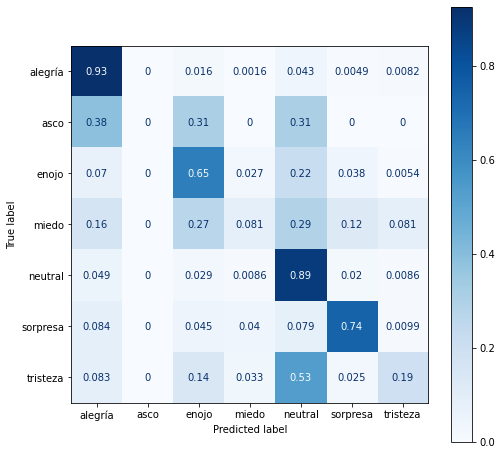

In [ ]:
best_svm_classifier = svm_classifiers[100]

print(get_confusion_matrix(y_validation, svm_predictions[100]))

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(best_svm_classifier, X_validation, y_validation, cmap=plt.cm.Blues, normalize='true', ax=ax)

#### Decision Tree

[[498   1  25  13  49  14  10]
 [  4   0   3   0   6   0   0]
 [ 39   1  66  11  48  18   3]
 [ 20   1   9   4  30  17   5]
 [ 23   1  23   3 278  10  12]
 [ 17   0   7   5  32 138   3]
 [  7   0  18   2  69   8  17]]


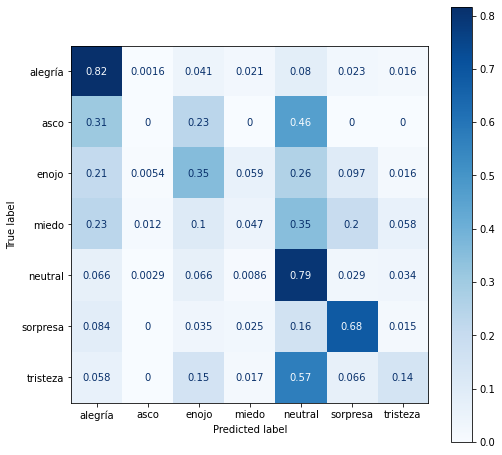

In [ ]:
best_decision_tree_classifier = decision_tree_classifiers_gini[10]

print(get_confusion_matrix(y_validation, decision_tree_predictions_gini[10]))

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(best_decision_tree_classifier, X_validation, y_validation, cmap=plt.cm.Blues, normalize='true', ax=ax)

#### Naive Bayes

[[296   7  61  10  36 106  94]
 [  2   1   5   1   1   2   1]
 [ 13   9  58   3  20  46  37]
 [  5   1  10   6   8  42  14]
 [ 11   5  45   8  96 129  56]
 [  8   0   9   8   5 152  20]
 [  9   0  16   2  22  31  41]]


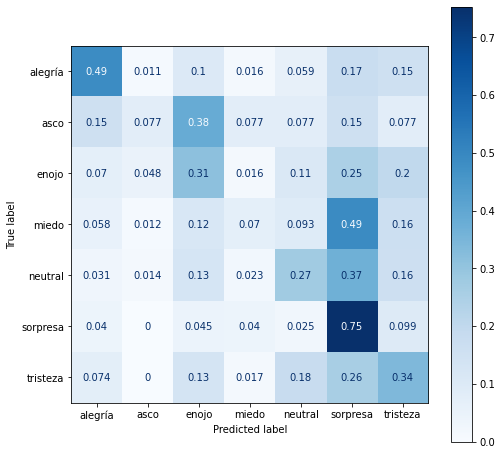

In [ ]:
print(get_confusion_matrix(y_validation, naive_bayes_prediction))

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(naive_bayes_classifier, X_validation, y_validation, cmap=plt.cm.Blues, normalize='true', ax=ax)

### Análisis

**¿Qué clasificador tiene mejor resultado con este problema? ¿Cuál es la posible razón?**

De los tres clasificadores, aquel con el mejor resultado, y con bastante margen de los demás, fue SVM. Esto puede deberse a que se procesaron las características desde pixeles hasta landmarks faciales, se redujo el tamaño de las características en cierta medida, y al mismo tiempo se concentró al clasificador a fijarse en esos puntos específicos. El kernel logra diferenciar correctamente los espacios de características, y se logran generar los hiperplanos adecuados. El kernel que tuvo el mejor resultado fue el `linear`, pero el resto de los probados, `poly` y `rbf`, tuvieron un rendimiento bien similar.

El rendimiento de estos clasificadores es superior a aquel de los árboles de decisión, y una posible razón es que a estos les puede costar detectar ciertas diferencias y reducir la entropía entre los niveles al momento de pasar entre nodos.

**¿Por qué le podría ir mal al peor de los clasificadores?**

El peor de los clasificadores fue Naive Bayes. Esto puede deberse a que el clasificador se basa en la probabilidad de que un conjunto de características específicas estén ligadas a una clase específica. Dado que estamos derivando nuestro espacio de características a partir de los landmarks de las caras, el espacio posible de características es muy grande como para abarcarlo completamente por un set de entrenamiento. A esto se suma que si bien se usó una cantidad razonable de datos para entrenar el modelo (alrededor de 12500), esta cantidad no se acerca a cubrir todas las posibles combinaciones que pueden existir de características. Es por esto que este clasificador no funciona al mismo rendimiento que el resto.

## Parte 4

### Matriz de confusión para clasificador con mejor resultado

**SVM** 
- kernel: `linear`
- Slack (C): `100`

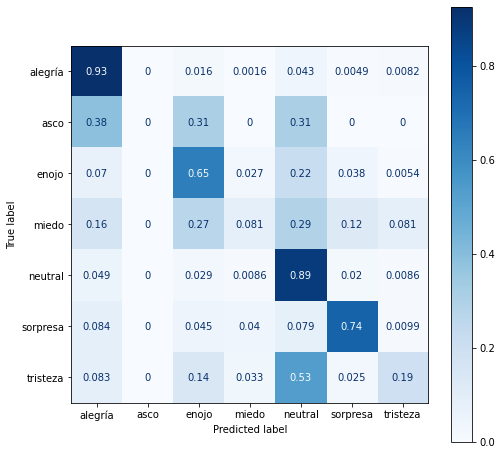

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(best_svm_classifier, X_validation, y_validation, cmap=plt.cm.Blues, normalize='true', ax=ax)

**¿Cuál es el error más común?**

Hubieron bastantes errores, pero el con mayor peso es el de clasificar la **tristeza** como **neutral**. Los datos de tristeza se predijeron como neutrales un 53% de las veces, y sólo se predijeron correctamente un 19%.

Una de las razones puede deberse a la similitud de los landmarks entre las emociones de `neutral` y `tristeza`, como se puede en la celda de abajo. Se puede notar que no existe una diferencia notable a simple vista, ni una característica que sea distintiva de cada set. De esta manera, le es difícil al clasificador SVM "separar" las características en el hiperespacio, y generar hiperplanos que permitan hacer una distinción correcta.

Otra razón relacionada a la anterior, puede ser que en el dataset, los datos marcados como `neutral` son 3 veces más abundantes que los de `tristeza`, por lo que al entrenar el clasificador, se introduce un *bias* a tender a clasificar como neutral en lugar de tristeza.

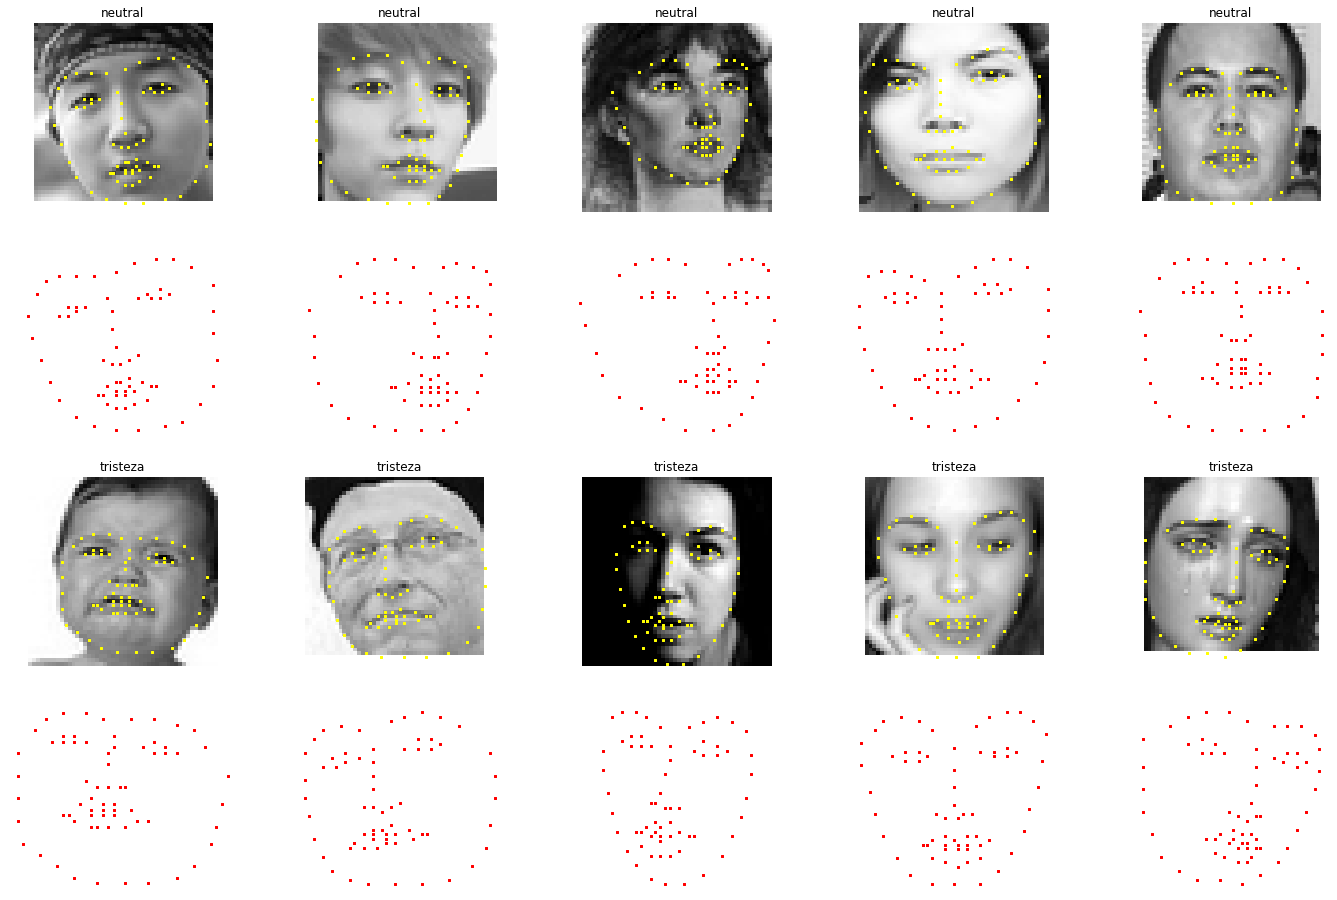

In [ ]:
sample_size = 5

neutral_sample = filtered_df[filtered_df['emotion'] == 'neutral'].iloc[:sample_size]
tristeza_sample = filtered_df[filtered_df['emotion'] == 'tristeza'].iloc[:sample_size]

fig, axs = plt.subplots(4, sample_size)
fig.set_size_inches((24,16))


for k, sample in enumerate([neutral_sample.iterrows(), tristeza_sample.iterrows()]):
    k = k*2
    for i, row in enumerate(sample):
        row = row[1]
        image = row.pixels
        axs[k][i].imshow(row['pixels'], cmap='gray')
        axs[k][i].axis('off')
        axs[k][i].set_title(row['emotion'])
        res = fr.face_landmarks(image)
        if res:
            flatten = [item for sublist in res[0].values() for item in sublist]
            x, y = zip(*flatten)
            axs[k][i].scatter(x, y, 8, 'yellow', marker='s')
            axs[k+1][i].set_aspect('equal', adjustable='box')
            axs[k+1][i].axis('off')
            axs[k+1][i].invert_yaxis()
            axs[k+1][i].scatter(x, y, 8, 'red', marker='s')


In [ ]:
print("Clases set test")
print(test_set['emotion'].value_counts())

print("Clases set validation")
print(validation_set['emotion'].value_counts())

print("Clases set train")
print(train_set['emotion'].value_counts())

Clases set test
alegría     580
neutral     389
sorpresa    197
enojo       165
miedo       115
tristeza     88
asco         11
Name: emotion, dtype: int64
Clases set validation
alegría     610
neutral     350
sorpresa    202
enojo       186
tristeza    121
miedo        86
asco         13
Name: emotion, dtype: int64
Clases set train
alegría     4729
neutral     3034
sorpresa    1547
enojo       1495
tristeza     970
miedo        818
asco          87
Name: emotion, dtype: int64


**¿Qué categoría obtiene el mejor rendimiento?**

El más alto es **alegría**, las cuales se clasifican correctamente el 93% de las veces.

Una posibilidad de este resultado, puede deberse a que en el dataset, los datos de alegría son los más abundantes, con bastante marge del resto, por lo que el modelo se entrena "mejor" para clasificar específicamente esos datos y discernirlos del resto.

Además, analizando visualmente los landmarks, se pueden detectar características significativas que ayudarían al clasificador a predecir correctamente, como las comisuras apuntando hacia arriba, la curvatura de la boca, y la forma de los ojos.

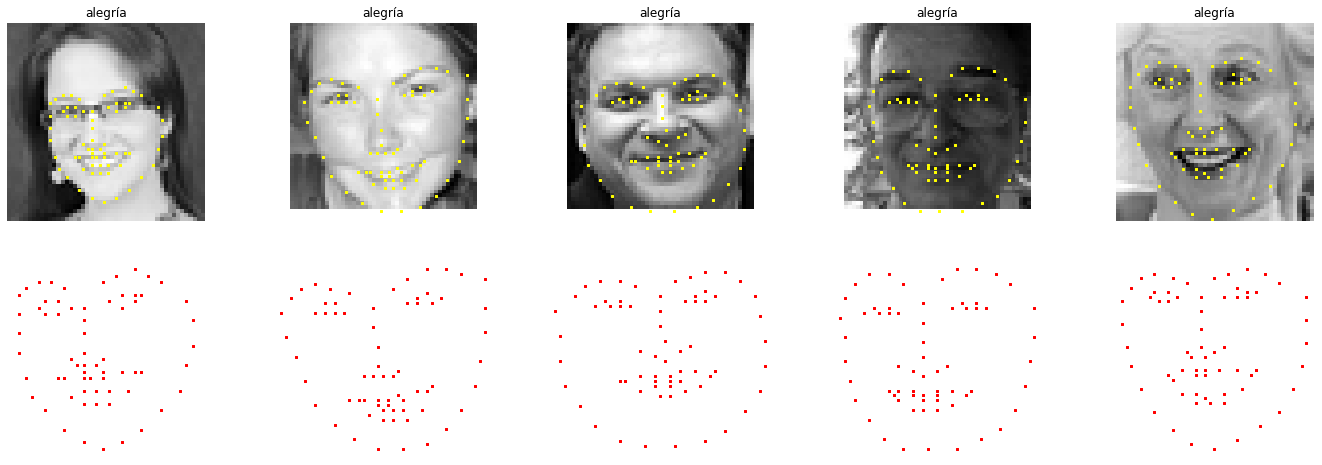

In [ ]:
sample_size = 5

alegria_sample = filtered_df[filtered_df['emotion'] == 'alegría'].iloc[:sample_size]

fig, axs = plt.subplots(2, sample_size)
fig.set_size_inches((24,8))

for i, row in enumerate(alegria_sample.iterrows()):
    row = row[1]
    image = row.pixels
    axs[0][i].imshow(row['pixels'], cmap='gray')
    axs[0][i].axis('off')
    axs[0][i].set_title(row['emotion'])
    res = fr.face_landmarks(image)
    if res:
        flatten = [item for sublist in res[0].values() for item in sublist]
        x, y = zip(*flatten)
        axs[0][i].scatter(x, y, 8, 'yellow', marker='s')
        axs[1][i].set_aspect('equal', adjustable='box')
        axs[1][i].axis('off')
        axs[1][i].invert_yaxis()
        axs[1][i].scatter(x, y, 8, 'red', marker='s')


**¿Cuál es el más bajo?**

El más bajo es claramente **asco**. De hecho, el clasificador no lo eligió en ningún caso al predecir. La principal razón de esto debe ser que la cantidad de datos de tipo asco es muy reducida, sólo 87 para el set de training, comparado a los casi 5000 de alegría. Debido a esto, el modelo no es capaz de analizar casos suficientes para separar el cluster que identifica a los datos de asco. El modelo simplemente toma los datos como "outliers", y al parecer los ignora al hacer la predicción.


## Parte 5

## Parte 6